# 《统计方法与机器学习》实践作业1

10211900416 郭夏辉

Due Day: 2023.10.04
## 背景描述

为了调查吃巧克力对心血管健康的影响，实验由三种类型的巧克力组成：100g的黑巧克力，含有200mg全脂牛奶的100g黑巧克力和200g的牛奶巧克力。12个实验对象：7女5男。在不同的天数里，每个实验对象将吃一种类型的巧克力，一个小时后测量他们血浆的总抗氧能力。

## 数据描述

实验次序本身具有随机性，无需再随机化。请使用Project_1.csv中的数据集。数据字典如下表所示。

|  变量名   |  变量含义  | 变量类型 | 变量取值范围 |
| :-------: | :--------: | :------: | :----------: |
| Chocolate | 巧克力类型 | 分类变量 | \{1, 2, 3\}  |
| Capacity  |  血浆浓度  | 连续变量 |      R       |

## 问题

注： 显著性水平$\alpha$取 0.05。

1. 两两比较 3 种巧克力对心血管健康的影响是否存在差异。
2. 判断 3 种巧克力对心血管健康的影响是否有差异。
3. 试说明所使用模型的合理性。
4. 估计食用这 3 种巧克力一小时后血浆的总抗氧能力。请分别给出点估计和区间估计。
5. 用Bonferroni方法比较吃了 3 种巧克力后，一个小时的血浆总抗氧能力两两是否存在差异。
6. 用Tukey方法比较吃了 3 种巧克力后，一个小时的血浆总抗氧能力两两是否存在差异。采用以下两种不同的方法来解决这个问题：

- 直接调用python中现有函数；
- 用蒙特卡洛随机模拟分布的方式，确定 t 化极差统计量的分位数 $q_{1-\alpha}(a, df)$，计算临界值(critical value) $c = q_{1-\alpha}(a, df) \hat{\sigma}/\sqrt{m}$。

7. 基于这个例子，请评述一下Bonferroni方法和Tukey方法的异同。

In [1]:
import os # 修改工作目录

import numpy as np
import pandas as pd
import scipy.stats as stats # 统计函数
import matplotlib.pyplot as plt
from plotnine import * # ggplot 绘图
from plotnine.data import mpg


import math

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import f
from scipy.stats import t
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
alpha = 0.05 # 显著性水平
a = 3 # 水平数
m = 12 # 重复次数
n = a*m # 样本量

Data = pd.read_csv("Project_1.csv")

## 问题1：两两比较 3 种巧克力对心血管健康的影响是否存在差异。

### 拒绝域法

假设某一种巧克力吃完之后一小时后血浆浓度为$x_1,x_2,...x_m$

另一种巧克力吃完之后一小时后血浆浓度为$y_1,y_2,...y_n$

这两组数据来自两个方差相等的独立正态分布，我们为了比较这两种数据是否存在差异，主要就是在比较它们的均值${\mu}_1$和${\mu}_2$，假设检验的问题为：
$H_0: {\mu}_1={\mu}_2$   vs   $H_1: {\mu}_1 \not= {\mu}_2$

根据概率论与数理统计中的所学知识:

$\frac{(\bar{x}-\bar{y})-({\mu}_1-{\mu}_2)}{s_w \sqrt{\frac{1}{m} + \frac{1}{n}} } \sim t(m+n-2)$

其中$s_w^2 = \frac{m-1}{m+n-2}s_x^2 + \frac{n-1}{m+n-2}s_y^2  $

然后检验统计量构造为$t=\frac{(\bar{x}-\bar{y})}{s_w \sqrt{\frac{1}{m} + \frac{1}{n}} }$

由于 $m=n$ 可以简化$t$为

$t=\frac{\bar{x}-\bar{y}}{ \sqrt{ \frac{1}{m} (s_x^2 + s_y^2) } }$

拒绝域为

$\{|t|>t_{1 − {\alpha}/2}(2m−2)\}$


落入拒绝域就拒绝原假设，则认为两种巧克力对心血管健康的影响存在差异；否则认为不存在差异。

然后这个题目要求的是两两比较，所以只用分3种情况两两去比就行。

In [3]:
data1 = Data[['Chocolate','Capacity']] # 选择几列
data1.columns =  ['Chocolate', 'Capacity']
data1tmp = data1.values
# 在每行的第一列的元素等于x时，将这一行的第二列的元素(数据)取出来
group = [data1tmp[data1tmp[:,0] == x,1] for x in [1, 2, 3]] 
#print(group)

# 两样本t检验
t12, p12 = stats.ttest_ind(group[0], group[1]) #样本1和2
t23, p23 = stats.ttest_ind(group[1], group[2]) #样本2和3
t13, p13 = stats.ttest_ind(group[0], group[2]) #样本1和3
t_val = t.ppf(1-alpha/2,2*(m-1)) #分位数

if abs(t12) > t_val:
    print('落入拒绝域，样本1和2存在差异')
else:
    print('落入接受域，样本1和2不存在差异')

if abs(t23) > t_val:
    print('落入拒绝域，样本2和3存在差异')
else:
    print('落入接受域，样本2和3不存在差异')

if abs(t13) > t_val:
    print('落入拒绝域，样本1和3存在差异')
else:
    print('落入接受域，样本1和3不存在差异')
    
print("t_val=",t_val)
print("|t12|=",abs(t12)," |t23|=",abs(t23)," |t13|=",abs(t13))

落入拒绝域，样本1和2存在差异
落入接受域，样本2和3不存在差异
落入拒绝域，样本1和3存在差异
t_val= 2.0738730679040147
|t12|= 11.10565260090929  |t23|= 0.4126071170622644  |t13|= 12.047774079768462


### p值法

In [4]:
if p12 < alpha:
    print('落入拒绝域，样本1和2存在差异')
else:
    print('落入接受域，样本1和2不存在差异')

if p23 < alpha:
    print('落入拒绝域，样本2和3存在差异')
else:
    print('落入接受域，样本2和3不存在差异')

if p13 < alpha:
    print('落入拒绝域，样本1和3存在差异')
else:
    print('落入接受域，样本1和3不存在差异')
    
print("p12=",p12,"p23=",p23,"p13=",p13)

落入拒绝域，样本1和2存在差异
落入接受域，样本2和3不存在差异
落入拒绝域，样本1和3存在差异
p12= 1.733093968209115e-10 p23= 0.6838877988482657 p13= 3.683389152570871e-11


综上，只有类型2与3巧克力对心血管健康的影响不存在显著差异，类型1与3、类型1与2对心血管健康的影响存在显著差异

## 问题2：判断 3 种巧克力对心血管健康的影响是否有差异。

### F检验统计量与单因子方差分析表

假设检验的问题转化为了

$H_0: {\mu}_1={\mu}_2={\mu}_3$ vs $H_1: {\mu}_1,{\mu}_2,{\mu}_3中存在一对是不相等的$

根据课程内容，利用单因子方差分析:

$\frac{SS_E}{{\sigma}^2}\sim {\chi}^2 (n-a)$

$H_0$成立时，有:

$\frac{SS_A}{{\sigma}^2} \sim {\chi}^2 (a-1)$

$SS_A$与$SS_E$相互独立，$F=\frac{\frac{SS_A}{a-1}}{\frac{SS_E}{n-a}} \sim F(a-1,n-a)$ 这个F可以作为检验统计量

然后，可以得到拒绝域是${F \geq F_{1-{\alpha}}(a-1,n-a)}$

我们只要得到对应的单因子方差分析表即可很好地比较。

In [5]:
model = ols('Capacity ~ C(Chocolate)', data1).fit()
result2 = round(anova_lm(model), 4)
F, p0 = stats.f_oneway(group[0],group[1],group[2])
print('单因子方差分析表：\n', result2)
F_val = f.ppf(1 - alpha,dfn=a-1,dfd=n-a)

print('F_val = ',F_val,'F = ',F)
if F > F_val:
    print('落入拒绝域,拒绝H0,3种巧克力中是有差异的')
else:
    print('落入接受域,接受H0,3种巧克力可以认为没有差异')

单因子方差分析表：
                 df     sum_sq   mean_sq        F  PR(>F)
C(Chocolate)   2.0  1952.6439  976.3219  93.5756     0.0
Residual      33.0   344.3058   10.4335      NaN     NaN
F_val =  3.2849176510382883 F =  93.57559776071176
落入拒绝域,拒绝H0,3种巧克力中是有差异的


### p值法

In [6]:
if p0 < alpha:
    print('落入拒绝域,拒绝H0,3种巧克力中是有差异的')
else:
    print('落入接受域,接受H0,3种巧克力可以认为没有差异')

落入拒绝域,拒绝H0,3种巧克力中是有差异的


## 问题3：试说明所使用模型的合理性。

单因子方差分析模型中：

$y_{ij} = \mu + \alpha_i + \epsilon_{ij}$ 的误差 $\epsilon_{ij}$ 服从正态独立分布，其均值为零，方差为未知常数$\sigma^2$。 

想要判断ANOVA模型是否恰当，可以利用残差检测来进行分析。  
处理 $i$ 的观测值 $j$ 的残差定义为：$e_{ij} = y_{ij} - \hat{y}_{ij}$ 

其中$\hat{y}_{ij}$是对$y_{ij}$的一个估计： 
$\hat{y}_{ij} = \hat{\mu} + \hat{\alpha}_i = \overline{y}_{··} + (\overline{y}_{i·} - \overline{y}_{··}) = \overline{y}_{i·}$

### 1正态性检验

#### qq图

利用qq图（The quantitle-quantile plot），来检验数据分布的相似性。令X轴为正态分布的分位数，Y轴为样本分位数。假如这两者构成的点分布在一条直线上，就证明样本数据与正态分布存在线性相关性，即服从正态分布。

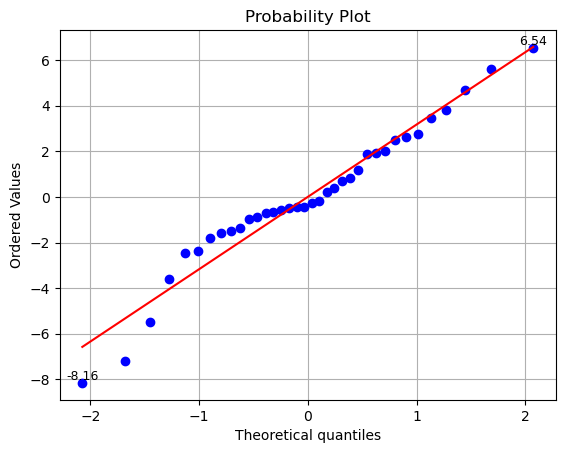

In [7]:
# 先计算残差
data1tmp2 = data1tmp * 1
for k in [1,2,3]:
    groups = data1tmp2[data1tmp2[:,0] == k,1] # y_ij
    data1tmp2[data1tmp2[:,0] == k,1] = groups - np.mean(groups) # e_ij
res = data1tmp2[:, 1]

# 再用qq图进行正态性检验
res = res.astype(float) * 1
osm,osr = stats.probplot(res, dist = 'norm', plot = plt)

x1 = osm[0][0]
y1 = osm[1][0]
plt.text(x1, y1, '%.2f' % float(y1), ha = 'center', va = 'bottom',fontsize = 9)

x2 = osm[0][-1]
y2 = osm[1][-1]
plt.text(x2, y2, '%.2f' % float(y2), ha = 'center', va = 'bottom',fontsize = 9)

plt.grid()
plt.show()

由上图可以看出，总体上来看，误差的分布近似正态

在中位数以下时，正态性并不是很好。中位数以上，数据较为满足正态性。

在样本数量较少时，采用qq图可能不太准确。

#### Shapiro-Wilk检验
SW检验有两个基本假设

H0：样本中所有来自总体分布服从正态分布 vs H1：样本中所有来自总体分布不服从正态分布 

利用方法stats.shapiro()检验正态性，输出结果中第一个为统计量，第二个为P值

（统计量越接近 1 越表明数据和正态分布拟合的好，P值大于指定的显著性水平，接受原假设，认为样本来自服从正态分布的总体）

SW检验是适用于小样本的。


In [8]:
# SW检验
SW, pVal1 = stats.shapiro(res)
print(SW)
print(pVal1)

if pVal1 > alpha:
    print('接受H0')
else:
    print('p-value < alpha, 落入拒绝域，拒绝H0') 

0.9625398516654968
0.257159024477005
接受H0


根据实际结果，统计量SW为 0.96，接近 1
且P值为 0.26，大于指定的显著性水平 0.05。
故认为残差来自服从正态分布的总体。 

### 2方差齐性检验

#### Bartlett检验

在Bartlett检验中，所使用的检验统计量为
$$
\chi_0^2 = 2.3026 \frac{q}{c}
$$
其中，
- $ q = (n - a) \log_{10}s_p^2 - \sum_{i=1}^a (m_i-1)  \log_{10}s_i^2 $；
- $c = 1 + \frac{1}{3(a-1)}\left( \sum_{i=1}^a (m_i-1)^{-1} - (n-a)^{-1} \right)$；
- $s_p^2 = \frac{\sum_{i}  (m_i-1)s^2_i}{n-a}$；
- $s_i^2$ 表示第$i$组数据的样本方差。

注意到，如果样本方差$s_i^2$差异大，那么$q$非常大；如果样本方差$s_i^2$完全一致，那么$q$为零。基于这个想法，如果检验统计量$\chi_0^2$过大，那么我们就拒绝原假设。具体来说，我们拒绝原假设当且仅当
$$
\chi_0^2 > \chi_{1-\alpha,a-1}^2
$$
其中$\chi_{1-\alpha,a-1}^2$是自由度为$a-1$的卡方分布的$1-\alpha$分位数。


然而，Bartlett检验存在一个**缺陷**：Bartlett检验对正态分布假定非常敏感。如果数据背离正态性假定，建议不要使用Bartlett检验。

In [9]:
# Bartlett检验
bart, pVal2 = stats.bartlett(group[0], group[1], group[2])
bart1 = stats.chi2.ppf(1-alpha, a-1)

# Bartlett检验统计量
print('Bartlett检验统计量：', bart)
print('Bartlett检验的P值为：', pVal2)
print('𝜒_(1-𝛼,𝑎−1)^2: ',bart1)

if bart > bart1:
    print('𝜒_0^2 > 𝜒_(𝛼,𝑎−1)^2,落入拒绝域，拒绝 H0.')
else:
    print('接受 H0')  
    
# p值法
if pVal2 < alpha:
    print('p-value < alpha,落入拒绝域，拒绝 H0.')
else:
    print('接受 H0')  

Bartlett检验统计量： 0.42469835124064104
Bartlett检验的P值为： 0.8086822761266198
𝜒_(1-𝛼,𝑎−1)^2:  5.991464547107979
接受 H0
接受 H0


由结果可知，Bartlett检验的P值远远大于 0.05 

并且Bartlett检验统计量小于5.99

故接受原假设，即残差具有方差齐性

#### Levene检验

因为 Bartlett 对正态性假定的敏感性，所以对于背离正态性的数据，可以通过修正后的 Levene 检验来解决这个问题。令
$$
y_{ij}^{\ast} = |y_{ij} - \tilde{y}_{i}|, i = 1,2,\cdots,a; j = 1,2,\cdots,n_i.
$$
其中，$\tilde{y}_{i}$表示第$i$组数据的中位数。基于$\{y_{ij}^{\ast}\}$来构建$F$统计量。这个统计量可以用来评价每组数据的绝对偏差的均值是否相等，从而可以判断每组数据的波动是否一致。

In [10]:
# Levene检验
lene, pVal3 = stats.levene(group[0], group[1], group[2])
print('Levene检验统计量：', lene)
print('Levene检验的P值为：', pVal3)
if pVal3 < alpha:
    print('p-value < alpha,落入拒绝域，拒绝 H0.')
else:
    print('接受 H0')  

Levene检验统计量： 0.021277420918676362
Levene检验的P值为： 0.9789607652073091
接受 H0


由结果可知，Levene检验的P值大于 0.05，故残差具有方差齐性。

### 3独立性检验

#### Durbin-Watson 检验

Durbin-Watson检验（简称“DW检验“）是一种检验序列是否存在一阶自相关性的常用方法。对于残差序列$\{e_i, i = 1,2,\cdots,n,\cdots\}$，考虑残差相关性方程为
$$
e_{i} = \rho e_{i-1} + v_{i}, \quad v_i \overset{i.i.d}{\sim} N(0,\sigma_v^2)，
$$
其中，$|\rho| < 1$。

在Durbin-Watson检验中，我们需要检验这样一对假设
$$
H_0 : \rho = 0 \quad \text{vs} \quad H_1: \rho > 0.
$$
可以注意到，$\rho = 0$表示残差序列无自相关性。也就是说，如果我们接受原假设，那么我们就认为序列数据是满足独立性的。

DW检验统计量为
$$
DW = \frac{\sum_{i=2}^n (e_i - e_{i-1})^2}{\sum_{i=1}^n e_{i}^2}
$$
可以注意到，$DW \approx 2(1-r_1)$，其中$r_1$表示一阶滞后样本自相关系数，即
$$
r_1 = \frac{\sum_{i=2}^{n} e_{i-1}e_{i}}{\sum_{i=1}^n e_{i}^2}.
$$
对于无相关性的残差序列，$r_1$接近于零，所以$DW$统计量接近于$2$。

判断规则为
- 如果 $DW < d_L$, 那么拒绝原假设；
- 如果 $DW > d_U$, 那么接受原假设；
- 如果 $d_L \leq DW \leq d_U$, 那么无法判断。

$d_L$和$d_U$与样本量、线性模型中特征个数以及显著性水平有关，具体可以查表。

在python中statsmodels.stats.stattools.durbin_watson()可以用于计算Durbin Watson检验统计量，但无法得到其临界值或者$p$值。还有一种较为**粗略**的判断方法：$DW$一般介于0到4之间。如果$DW$值接近于2，我们一般可以认为残差序列不具有相关性。

In [11]:
# Durbin-Watson检验
def durbin_watson(residuals):
    nume = sum(np.diff(residuals.T) ** 2)
    deno = sum(residuals ** 2)
    return nume / deno
dw = durbin_watson(res)
print('Durbin-Watson检验的检验统计量为：',dw)

Durbin-Watson检验的检验统计量为： 2.299061678853025


Durbin-Watson检验的统计量约为：2.3，非常接近2，在 0-4 之间，没有违反独立性的假定。 

综上三个方面，可以知道该实验用One-way ANOVA模型是恰当的

## 问题4：估计食用这 3 种巧克力一小时后血浆的总抗氧能力。请分别给出点估计和区间估计。

$y_{ij}\sim N({\mu}+{\alpha}_i,{\sigma}^2)$

似然函数
$L({\mu},{\alpha}_1,{\alpha}_2,{\alpha}_3,{\sigma}^2 )=\prod_{i=1}^3 \prod_{j=1}^{12}\frac{1}{{\sigma}\sqrt{2{\pi}}}exp\{-\frac{(y_{ij}-{\mu}-{\alpha}_i)^2}{2{\sigma}^2}\} $

取对数，为:
$l = -\frac{n}{2}ln(2{\pi} {\sigma}^2 ) - {\sum}_{i=1}^{3} {\sum}_{j=1}^{12} -\frac{(y_{ij}-{\mu}-{\alpha}_i)^2}{2{\sigma}^2}$

然后再对各参数求偏导，可得:

$\frac{\partial l}{\partial {\mu}}=\frac{1}{{\sigma}^2}{\sum}_{i=1}^{3} {\sum}_{j=1}^{12}(y_{ij}-{\mu}-{\alpha}_i)=0 $

$\frac{\partial l}{\partial {\alpha}_i}=\frac{1}{{\sigma}^2} {\sum}_{j=1}^{12}(y_{ij}-{\mu}-{\alpha}_i)=0,i=1,2,3$

$\frac{\partial l}{\partial {\sigma}^2}=-\frac{n}{2{\sigma}^2}+\frac{1}{2{\sigma}^4}{\sum}_{i=1}^{3} {\sum}_{j=1}^{12}(y_{ij}-{\mu}-{\alpha}_i)^2=0$

然后由于效应模型存在约束${\sum}_{i=1}^{3}{\alpha}_i =0$

可得各参数的极大似然估计:
$\hat{{\mu}} = \frac{1}{36} {\sum}_{i=1}^{3} {\sum}_{j=1}^{12}y_{ij} $

$\hat{{\alpha}_i}=\frac{1}{12} {\sum}_{j=1}^{12}y_{ij} - \frac{1}{n} {\sum}_{i=1}^{3} {\sum}_{j=1}^{12}y_{ij} $

$\hat{{\sigma}^2_{MLE}}= \frac{1}{n} SS_E$

$\hat{{\sigma}^2_{MLE}}$并不是${\sigma}^2$的无偏估计，一般采用的是$\hat{{\sigma}^2 }= \frac{1}{n-a} SS_E$

写了这么一大堆，接下来的代码来具体地点估计一下${\mu}$的值

In [12]:
print(np.mean(data1['Capacity']))

105.64722222222221


区间估计其实就是在点估计的基础之上做了进一步的升级。

$ \frac{SS_E}{{\sigma}^2}\sim {\chi}^2 (n-a) $

$ \bar{y_{i.}} \sim N({\mu}+{\alpha}_i,\frac{{\sigma}^2}{m}),i=1,2,3$

$\bar{y_{i.}},i=1,2,3$ 与 $SS_E$ 相互独立

故$\frac{\sqrt{m} (\bar{y_{i.}}-{\mu}-{\alpha}_i )}{ \sqrt{ \frac{SS_E}{n-a} } } \sim t(n-a)$

则第i个均值${\mu}_i$的置信区间为

$[\bar{y_{i.}}-t_{1-{\alpha}/2}(n-a)\hat{\sigma}/{\sqrt{m}},\bar{y_{i.}}+t_{1-{\alpha}/2}(n-a)\hat{\sigma}/{\sqrt{m}} ]$

写了这么多，接下来的代码来具体地区间估计一下各${\mu}_i$的值

In [13]:
t_val_1 = t.ppf(1-alpha/2,n-a)
est_sigma_2 = 344.3058/(36-3) # 查表可知SSE = 344.3058
for i in range(3):
    print('[',np.mean(group[i])-t_val_1*np.sqrt(est_sigma_2/m),',',np.mean(group[i])+t_val_1*np.sqrt(est_sigma_2/m),']')


[ 114.16125381158714 , 117.95541285507953 ]
[ 98.80292047825381 , 102.5970795217462 ]
[ 98.28625381158713 , 102.08041285507952 ]


写到这里，我感觉自己并没有很好地解答这个问题——“估计食用这 3 种巧克力一小时后血浆的总抗氧能力的置信区间”，因为这个问题需要的是“总抗氧能力”，因此我需要去估计的是整体那个$\mu$

$\bar{y_{..}} = \frac{1}{n}\sum_{i=1}^a\sum_{j=1}^{m}y_{ij} \sim N({\mu},\frac{{\sigma}^2}{n})$

$\frac{\bar{y_{..}}-{\mu}}{\sqrt{ \frac{{\sigma}^2}{n}}} \sim N(0,1) $

$ \frac{SS_E}{{\sigma}^2}\sim {\chi}^2 (n-a) $

因此 $ \frac{\sqrt{n} (\bar{y_{..}}-{\mu} )}{\sqrt{\frac{SSE}{n-a}}} \sim t(n-a) $

可得${\mu}$的置信区间为

$[\bar{y_{..}}-t_{1-{\alpha}/2}(n-a)\sqrt{\frac{SSE}{n(n-a)}},\bar{y_{..}}+t_{1-{\alpha}/2}(n-a)\sqrt{\frac{SSE}{n(n-a)}} ]$

In [14]:
print('[',np.mean(data1['Capacity'])-t_val_1*np.sqrt(est_sigma_2/(n)),',',np.mean(data1['Capacity'])+t_val_1*np.sqrt(est_sigma_2/(n)),']')

[ 104.55194284966792 , 106.7425015947765 ]


## 问题5：用Bonferroni方法比较吃了 3 种巧克力后，一个小时的血浆总抗氧能力两两是否存在差异。

其实Bonferroni方法还是较容易理解的，就是把置信水平从原来的$1-\alpha$提高到了$1-\frac{\alpha}{a(a-1)}$

再更改了置信度之后，我们只用一组一组地去得出相应的$\mu_{i}-\mu_{i'}$的置信区间即可：

$$[(\bar{y_{i.}}-\bar{y_{i'.}})-t_{1-\frac{\alpha}{a(a-1)}}(n-a)\hat{\sigma}\sqrt{\frac{2}{m}},(\bar{y_{i.}}-\bar{y_{i'.}})+t_{1-\frac{\alpha}{a(a-1)}}(n-a)\hat{\sigma}\sqrt{\frac{2}{m}}]$$

接下来就是去比较这个置信区间把0覆盖了没有。

In [16]:
# 1,2比较
t_val_2 = t.ppf(1-alpha/(a*(a-1)),n-a)
print('[',np.mean(group[0]-group[1])-t_val_2*np.sqrt(2*est_sigma_2/m),',',end='')
print(np.mean(group[0]-group[1])+t_val_2*np.sqrt(2*est_sigma_2/m),']')
# 1,3比较
print('[',np.mean(group[0]-group[2])-t_val_2*np.sqrt(2*est_sigma_2/m),',',end='')
print(np.mean(group[0]-group[2])+t_val_2*np.sqrt(2*est_sigma_2/m),']')
# 2,3比较
print('[',np.mean(group[1]-group[2])-t_val_2*np.sqrt(2*est_sigma_2/m),',',end='')
print(np.mean(group[1]-group[2])+t_val_2*np.sqrt(2*est_sigma_2/m),']')

[ 12.03234039504803 ,18.684326271618637 ]
[ 12.549007061714697 ,19.200992938285303 ]
[ -2.8093262716186356 ,3.8426596049519715 ]


可以看到仅第二、三类的巧克力的均值差的置信区间把0给覆盖了，可以认为它们之间不存在显著差异。但是1,2和1，3这两组存在显著的差异。

这与我们在问题一中的结果是不谋而合的。

## 问题6：用Tukey方法比较吃了 3 种巧克力后，一个小时的血浆总抗氧能力两两是否存在差异。采用以下两种不同的方法来解决这个问题：

- 直接调用python中现有函数；
- 用蒙特卡洛随机模拟分布的方式，确定 t 化极差统计量的分位数 $q_{1-\alpha}(a, df)$，计算临界值(critical value) $c = q_{1-\alpha}(a, df) \hat{\sigma}/\sqrt{m}$。

根据课程所学知识：

在多重比较问题中，我们同时比较所有的平均值组合。这其中至少一对平均值组合不相等就构成了拒绝域$$W=\bigcup_{1\leq i<i'\leq a}\{|\bar{y_{i.}}-\bar{y_{i'.}}|\geq c_{ii'}\}$$

为了简化问题，我们假设$$对\forall i,i'\in\{1\leq i<i'\leq a\},c_{ii'}=c$$

由于在原假设成立时诸$\mu_{i}$都等于$\mu$，易得$$P(W)=P(max_{i}\frac{\bar{y_{i.}}-\mu}{\frac{\hat{\sigma}}{\sqrt{m}}}-min_{i}\frac{\bar{y_{i.}}-\mu}{\frac{\hat{\sigma}}{\sqrt{m}}}\geq\frac{c}{\frac{\hat{\sigma}}{\sqrt{m}}})$$

令$$q(a,df)=max_{i}\frac{\bar{y_{i.}}-\mu}{\frac{\hat{\sigma}}{\sqrt{m}}}-min_{i}\frac{\bar{y_{i.}}-\mu}{\frac{\hat{\sigma}} {\sqrt{m}}},df=n-a$$

由于$$\frac{\bar{y_{i.}}-\mu}{\frac{\hat{\sigma}}{\sqrt{m}}}\sim t(n-a)$$

所以我们可以把$q(a,df)$看成$a$个独立同分布的自由度为$df$的$t$分布的随机变量的极差。


In [17]:
# Tukey方法
Tukey= pairwise_tukeyhsd(endog = Data["Capacity"], groups=Data["Chocolate"],alpha=alpha)
print(Tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2 -15.3583    0.0 -18.5941 -12.1226   True
     1      3  -15.875    0.0 -19.1108 -12.6392   True
     2      3  -0.5167 0.9191  -3.7524   2.7191  False
------------------------------------------------------


可见，A巧克力与B巧克力、A巧克力与C巧克力对心血管健康的影响不同，而B巧克力与C巧克力对心血管健康的影响相同。

接着，我们再使用蒙特卡洛方法得到$q(a,df)$的分布。

在显著性水平$\alpha$下，由于$$P(W)=P(q(a,df)\geq\frac{c}{\frac{\hat{\sigma}}{\sqrt{m}}})=\alpha$$

我们可以得到$$c=q_{1-\alpha}(a,df)\frac{\hat{\sigma}}{\sqrt{m}}$$

只要将不同水平下的样本均值两两作差再取绝对值并与临界值$c$比较，就可以做出判断。如果超过临界值c,可以认为这两个水平之间有显著差异；否则认为他们并没有显著差异。

In [18]:
q=[]
testN = 100000
#用蒙特卡洛随机模拟分布
for i in range(testN): 
    random = np.random.standard_normal(a)
    random.sort()
    minn = random[0]
    maxx = random[a-1]
    chi = (np.random.chisquare(n-a))/(n-a)
    q.append((maxx - minn) / ( chi**0.5) )
q.sort()
# 1-alpha分位数再乘上模拟次数等于95000
# 求临界值c
# 根据问题2中的单因子方差分析表 MSE = 10.4335 = SSE/(n-a)
c_ans = q[95000]*((10.4335)**0.5 /(m)**0.5)
print(c_ans)

d12 = abs(np.mean(group[0])-np.mean(group[1])) #1,2组
d23 = abs(np.mean(group[1])-np.mean(group[2])) #2,3组
d13 = abs(np.mean(group[0])-np.mean(group[2])) #1,3组

print(d12,d23,d13)

if d12 < c_ans:
    print('接受原假设，1,2不存在明显差异')
else:
    print('拒绝原假设，1,2存在明显差异') 
    
if d23 < c_ans:
    print('接受原假设，2,3不存在明显差异')
else:
    print('拒绝原假设，2,3存在明显差异') 
    
if d13 < c_ans:
    print('接受原假设，1,3不存在明显差异')
else:
    print('拒绝原假设，1,3存在明显差异') 

3.231802824689934
15.358333333333334 0.5166666666666799 15.875000000000014
拒绝原假设，1,2存在明显差异
接受原假设，2,3不存在明显差异
拒绝原假设，1,3存在明显差异


可得类型1、2和类型1、3均值之间差的绝对值的大于c，故拒绝原假设，认为两者均值存在显著差异。

类型2、3均值之间差的绝对值小于c值，接受原假设，认为类型2、3均值不存在显著差异。

## 问题7：基于这个例子，请评述一下Bonferroni方法和Tukey方法的异同。

相同的地方：

1. 在这个例子中，两种方法的目的都是比较各个水平下的样本均值是否相等，也就是比较不同水平下对心血管健康的影响是不是相同的。

2. 无论采取什么样的比较，它们面向的都是$\frac{a(a-1)}{2}$对水平，都要进行$\frac{a(a-1)}{2}$次比较才能判断H0是不是要拒绝。

不同的地方：
1. Bonferroni方法先假定原假设成立，然后让每一对水平的均值之差都落入拒绝域的概率由$\alpha$降低到了$\frac{\alpha}{a(a-1)}$。保证当原假设成立的前提下，增大了某对水平均值差的置信区间，精度较差

2. Tukey方法将每对水平比较时拒绝域的临界值都设定为同一个值$c$。在这个原假设成立时，每对水平的均值之差落入接受域的概率等于$1-\alpha$。$c$与t分布极差统计量的分位数有关，只要求出t分布极差统计量的$1-\alpha$分位数，通过适当的变换就能把这个$c$给算出来。